In [14]:
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("./data/dataset.csv").iloc[:, 1:].dropna()

In [15]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.2)

In [16]:
from autogluon.tabular import TabularDataset, TabularPredictor

predictor = TabularPredictor.load("./Models")

# 기존 데이터 분포와 노이즈를 준 데이터의 분포

In [17]:
not_to_use = [
    "EX1.H4_PV",
    "EX1.H2O_PV",
    "EX1.MELT_P_PV",
    "EX1.H3_PV",
    "EX5.MELT_TEMP",
    "EX1.H2_PV",
    "EX4.MELT_TEMP",
    "EX1.Z3_PV",
    "EX2.MELT_TEMP",
    "EX3.MELT_TEMP",
    "EX1.MD_TQ",
]
og_data = train.loc[:, train.columns.difference(not_to_use)].iloc[:, :-1]

In [18]:
def plotting_hist(df):
    num_features = len(df.columns)

    nrows = 2
    ncols = (num_features + nrows - 1) // nrows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))

    for idx, feature in enumerate(df.columns):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]

        data = df.loc[:, feature].values

        ax.hist(data, bins=1000, color="skyblue", edgecolor="black", alpha=0.7)
        title = ax.set_title(f"Histogram of {feature}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Frequency")

    total_subplots = nrows * ncols
    if total_subplots > num_features:
        for i in range(num_features, total_subplots):
            row = i // ncols
            col = i % ncols
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

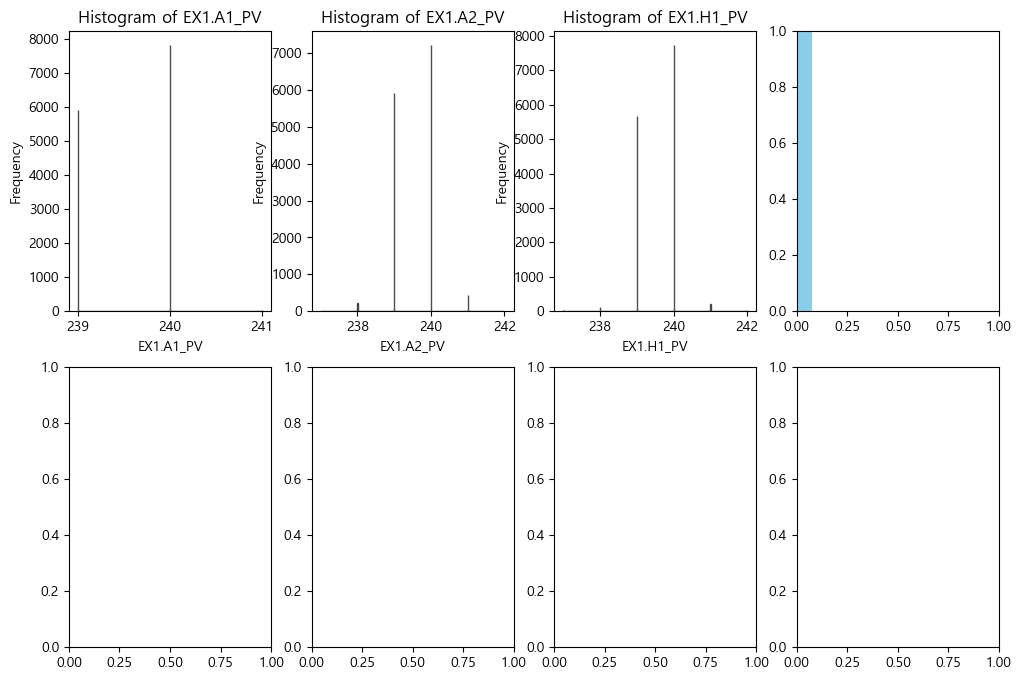

In [19]:
plotting_hist(og_data)

### 정규 분포 노이즈

In [ ]:
from scipy import stats

# 예: 정규분포 적합
mu, std = stats.norm.fit(og_data)

noise = np.random.normal(loc=mu, scale=std, size=og_data.shape)
noisy_data = (og_data + noise) / 2

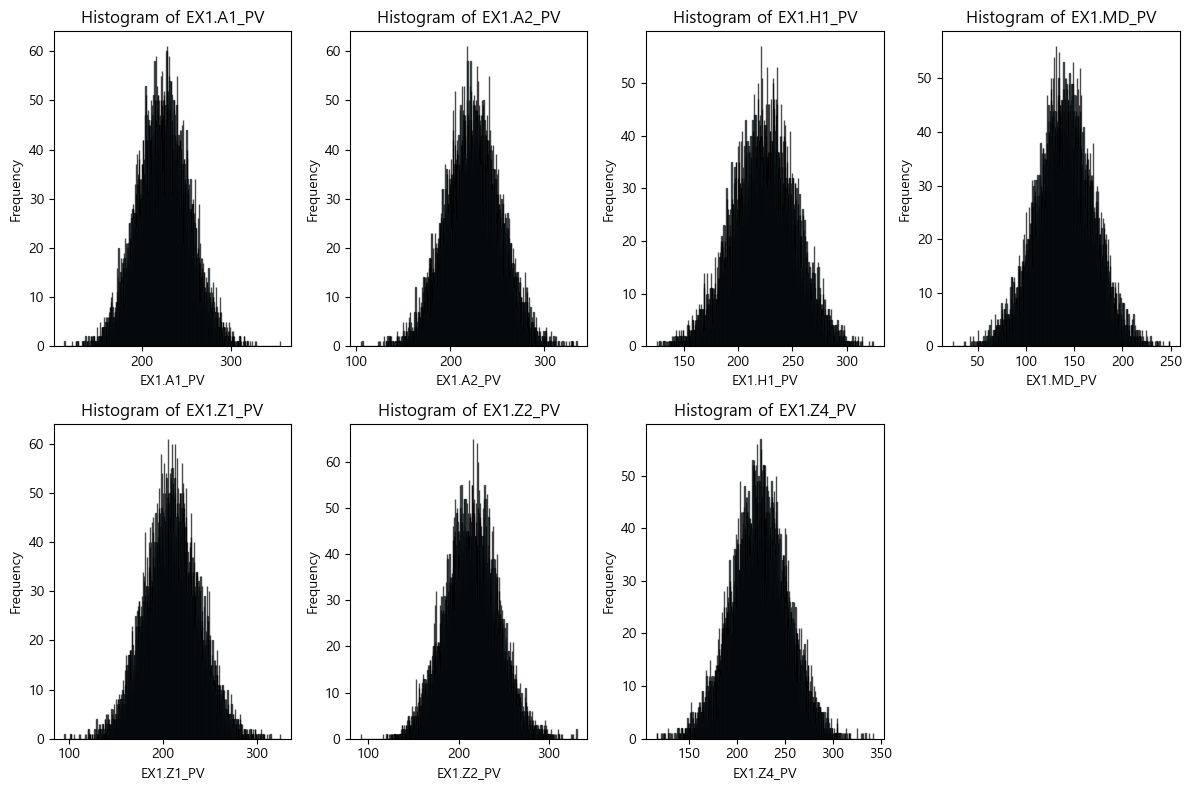

In [ ]:
plotting_hist(noisy_data)

### KDE 노이즈

데이터 분포를 확인했을 때, 특정 분포로 적합하기 어려우므로, KDE 노이즈 사용

In [ ]:
kde = stats.gaussian_kde(og_data.T)
noise = kde.resample(size=og_data.shape[0]).reshape(og_data.shape)
noisy_data = (og_data + noise) / 2

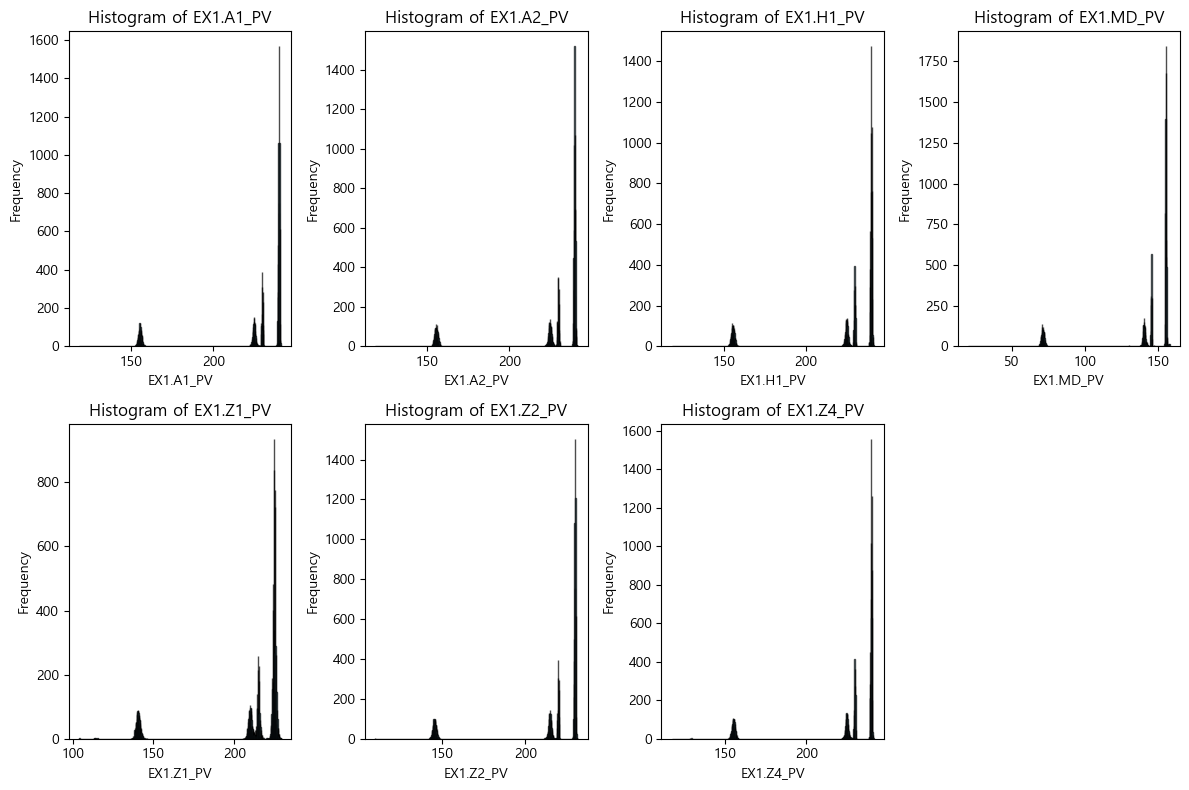

In [ ]:
plotting_hist(noisy_data)

# NSGA 시뮬레이션

In [ ]:
import optuna

not_to_use = [
    "EX1.H4_PV",
    "EX1.H2O_PV",
    "EX1.MELT_P_PV",
    "EX1.H3_PV",
    "EX5.MELT_TEMP",
    "EX1.H2_PV",
    "EX4.MELT_TEMP",
    "EX1.Z3_PV",
    "EX2.MELT_TEMP",
    "EX3.MELT_TEMP",
    "EX1.MD_TQ",
    "passorfail",
]
simulation_cols = train.columns.difference(not_to_use)


def modify_data_based_on_bounds(valid: pd.DataFrame, bounds: dict) -> pd.DataFrame:
    """
    각 컬럼에 대해 원본 구간 [L, U]를 계산한 후,
      new_lower = L + factor_lower * (U - L)
      new_upper = L + factor_upper * (U - L)
    의 새로운 구간을 결정합니다.

    이후 해당 구간으로 정규화 → 로짓 변환 → KDE 샘플링 → 역변환을 적용하여
    노이즈가 포함된 데이터를 생성합니다.

    bounds 딕셔너리는 각 컬럼별로 (factor_lower, factor_upper)를 제공합니다.
    """
    df_mod = valid.copy()
    eps = 1e-6  # 0 또는 1이 되는 것을 방지

    for col in df_mod.columns:
        # bounds가 정의된 컬럼만 수정 (나머지는 그대로)
        if col not in bounds:
            continue
        if col in not_to_use:
            continue

        x = df_mod[col].astype(float).values
        orig_lower = np.min(x)
        orig_upper = np.max(x)
        orig_range = orig_upper - orig_lower
        if orig_range <= 0:
            continue

        # trial에서 제시한 상대적 비율값 (factor_lower, factor_upper)
        factor_lower, factor_upper = bounds[col]
        new_lower = orig_lower + factor_lower * orig_range
        new_upper = orig_lower + factor_upper * orig_range

        if new_lower >= new_upper:
            continue

        # [new_lower, new_upper] 구간으로 정규화 및 클리핑
        x_norm = (x - new_lower) / (new_upper - new_lower)
        x_norm = np.clip(x_norm, eps, 1 - eps)

        # 로짓 변환
        y = np.log(x_norm / (1 - x_norm))

        # KDE를 이용한 노이즈 추가: y 공간에서 원본과 동일한 수의 샘플 생성
        kde = stats.gaussian_kde(y)
        y_sim = kde.resample(len(x)).flatten()

        # 역로짓 변환 및 원본 스케일 복원
        x_sim_norm = 1 / (1 + np.exp(-y_sim))
        x_sim = x_sim_norm * (new_upper - new_lower) + new_lower

        df_mod[col] = x_sim
    return df_mod

In [ ]:
trial_bounds = []


def objective(trial):
    global trial_bounds

    bounds = {}
    margin = 0.5  # 기본 구간의 ±20%까지 확장/축소 허용
    for col in simulation_cols:
        # 각 컬럼에 대해 두 개의 상대적 위치 값을 제안
        r1 = trial.suggest_float(col + "_bound1", low=-margin, high=1 + margin)
        r2 = trial.suggest_float(col + "_bound2", low=-margin, high=1 + margin)
        factor_lower = min(r1, r2)
        factor_upper = max(r1, r2)
        bounds[col] = (factor_lower, factor_upper)

    trial_bounds.append(bounds)

    # [시뮬레이션 영역의 폭] 계산: 각 컬럼의 새 구간 폭의 합
    sim_range_sum = 0
    for col in simulation_cols:
        x = train[col].astype(float).values
        orig_lower = np.min(x)
        orig_upper = np.max(x)
        orig_range = orig_upper - orig_lower
        factor_lower, factor_upper = bounds[col]
        new_range = (factor_upper - factor_lower) * orig_range
        sim_range_sum += new_range

    # trial에서 제시한 bounds를 반영해 검증 데이터 변형
    modified_val_features = modify_data_based_on_bounds(valid, bounds)

    predictions = predictor.predict(modified_val_features)

    acceptance_rate = 1 - (sum(predictions) / len(predictions))

    # 다목적 최적화 대상 (각 목표에 대해 방향을 아래와 같이 설정)
    # 1. acceptance_rate: 최대화
    # 2. sim_range_sum: 최대화 (더 넓은 시뮬레이션 영역)
    return acceptance_rate, sim_range_sum

In [ ]:
# Optuna를 통한 상한/하한 최적화
from optuna.samplers import NSGAIIISampler, NSGAIISampler

study = optuna.create_study(
    sampler=NSGAIISampler(),
    directions=[
        "maximize",
        "maximize",
    ],
)
study.optimize(objective, n_trials=2)

# 최적의 상한/하한 값 확인
print("Best trial len:", len(study.best_trials))
print("Best trial:", study.best_trials[0].params)

[I 2025-02-07 09:06:22,138] A new study created in memory with name: no-name-13e3abf4-3e6c-42d5-a167-3774af33b7d9
c:\Users\MoonDongWon\anaconda3\envs\manuf_cmp\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\MoonDongWon\anaconda3\envs\manuf_cmp\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreesClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\MoonDongWon\anaconda3\envs\manuf

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
from plotly.io import show
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

fig = optuna.visualization.plot_pareto_front(
    study,
    targets=lambda t: (t.values[0], t.values[1]),
    target_names=["합격률", "새롭게 설정한 상/하한 범위의 합"],
)

show(fig)

In [ ]:
from skcriteria import mkdm
from skcriteria.madm import simple
from skcriteria.agg import similarity
from skcriteria.preprocessing import scalers

pareto_solutions = []
for trial in study.best_trials:
    # trial의 모든 파라미터와 목표 값 (불량률 및 비용)을 함께 저장
    solution = trial.params
    solution["Defect_Rate"] = trial.values[0]  # 불량률
    solution["Cost"] = trial.values[1]  # 비용
    pareto_solutions.append(solution)

pareto_df = pd.DataFrame(pareto_solutions)

# 4. TOPSIS 적용
# `Defect_Rate`는 최소화, `Cost`는 최대화가 목표이므로 각각의 목표 설정
# 양의 이상적 솔루션으로 부터 가장 짧은 거리, 음의 이상적 솔루션으로 부터 가장 긴 거리
criteria_data = pareto_df[["Defect_Rate", "Cost"]].values
criteria_names = ["Defect_Rate", "Cost"]
criteria_min_max = [min, max]  # 최소화/최대화 설정

# 데이터 스케일링 및 TOPSIS 모델 설정
dm = mkdm(
    matrix=criteria_data,
    objectives=criteria_min_max,
    criteria=criteria_names,
    alternatives=pareto_df.index,  # trial 인덱스 사용
)

# 데이터 정규화 및 TOPSIS 적용
scaler = scalers.SumScaler(target="both")
dm = scaler.transform(dm)
topsis = similarity.TOPSIS()
decision = topsis.evaluate(dm)

# 결과 처리: 각 trial의 TOPSIS 점수 및 랭킹 추가
pareto_df["TOPSIS_Score"] = decision.e_.similarity  # 유사도 인덱스가 점수
pareto_df["Rank"] = pareto_df["TOPSIS_Score"].rank(ascending=False)  # 내림차순으로 랭크

# 최적 타협 해 선택
optimal_solution = pareto_df.sort_values(by="TOPSIS_Score", ascending=False).iloc[0]
print("TOPSIS 최적 타협 해:\n", optimal_solution)

# 전체 Pareto 해 집합과 TOPSIS 결과 표시
print("Pareto 해 집합과 TOPSIS 결과:\n", pareto_df)

ModuleNotFoundError: No module named 'skcriteria'